In [1]:
### Download the dataset ###
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip -q /content/drive/MyDrive/tiny-imagenet-2020.zip

In [3]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import os
import skimage
from skimage import io
%matplotlib inline

In [4]:
def read_files(X, Y, path):
  f = os.listdir(path)
  for i in tqdm(f):
    files = os.listdir(path +'/' + i)
    for j in files:
      img = cv2.imread(path +'/'+ i + '/' + j)
      X.append(img)
      Y.append(int(i[-3:]))
  return X, Y

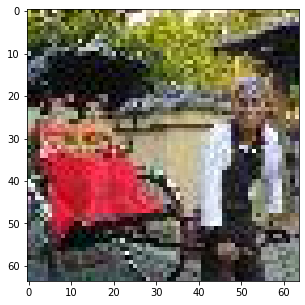

In [5]:
plt.figure(figsize=(10,5))
img = skimage.img_as_ubyte(io.imread('/content/tiny-imagenet-200/train/class_145/00002.jpg'))
plt.imshow(img)

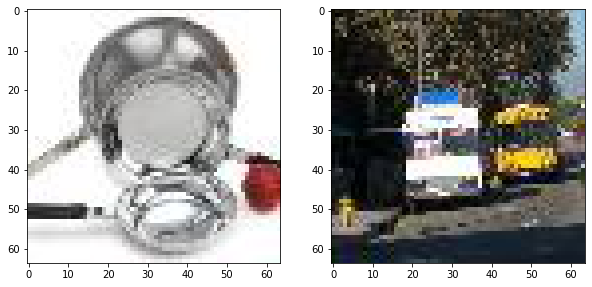

In [10]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(io.imread('/content/tiny-imagenet-200/train/class_148/00005.jpg'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(io.imread('/content/tiny-imagenet-200/train/class_150/00003.jpg'))
plt.imshow(mask)

In [29]:
class MyClass(torch.utils.data.Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
    
    def __getitem__(self, i):
        data = skimage.img_as_ubyte(self.X[i])
        if self.transform:
          data = self.transform(data)
        return data, self.Y[i]

    def __len__(self):
        return len(self.X)

In [14]:
from tqdm import tqdm
X = []
Y = []
X_train, Y_train = read_files(X, Y, "/content/tiny-imagenet-200/train")
val_x, val_y = read_files(X, Y, "/content/tiny-imagenet-200/val")
print(len(X_t), len(Y_t))

100%|██████████| 200/200 [00:01<00:00, 150.51it/s]

110000 110000


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split( X_t, Y_t, test_size=0.30, random_state=42)

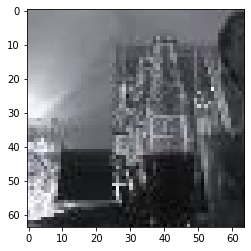

In [16]:
plt.imshow(skimage.img_as_ubyte(X_train[45]))

In [17]:

transform = transforms.Compose([transforms.ToTensor(),
                       transforms.CenterCrop(224),
                       transforms.Resize(256),
                       transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225))])

In [31]:
data_train = MyClass(X_train, Y_train, transform)
data_test = MyClass(X_test, Y_test, transform)
data_validation = MyClass(val_x, val_y, transform)

In [32]:
Train_Loader = torch.utils.data.DataLoader(dataset=data_train, batch_size=5, shuffle=True)
Test_Loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=5)
Validation_loader = torch.utils.data.DataLoader(dataset=data_validation, batch_size=3)

Решила попробовать две неросети и посчмотреть какая будет эффектривнее


In [33]:
import torchvision.models as models
resnet18 = models.resnet18()

In [22]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 1e-3)
lr = 1e-4

train_losses = []
val_losses = []

train_metrics = []
val_metrics = []

hist = {"train_loss": [],
        "train_iou": [],
        "val_loss": [],
        "val_iou": []}

num_epochs = 20

In [23]:
resnet18.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
for i in range(num_epochs):
    if i>0:
         print("Epoch %d/%d\t Loss mean: %f\t IoU mean: %f"% \
               (i, num_epochs, epoch_loss, epoch_iou))
         print("Epoch %d/%d\t Val Loss mean: %f\t Val IoU mean: %f"% \
               (i, num_epochs, val_loss, val_iou))
    
         plt.figure(figsize=(16, 6))
         plt.subplot(121)
         plt.plot(hist['train_loss'], label='train')
         plt.plot(hist['val_loss'], label='val')
         plt.legend()
         plt.grid()
        
         plt.subplot(122)
         plt.plot(hist['train_iou'], label='train_iou')
         plt.plot(hist['val_iou'], label='val_iou')
         plt.legend()
         plt.grid()
         plt.show()

    epoch_losses = []
    epoch_ious = []
    val_losses = []
    val_ious = []
    
    resnet18.train()
    for k, (img, mask) in enumerate(Validation_loader):  
        optimizer.zero_grad()
        y_pred = resnet18(img.cuda())
        loss = criterion(y_pred, mask.cuda())
        
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        iou = calc_iou(y_pred.cpu().detach().numpy()>0.1, 
                                  mask.numpy())
        epoch_ious.append(iou)
        
        
        if k%5 == 0:
            print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))
    
    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_iou = np.mean(np.array(epoch_ious))
    hist['train_iou'].append(epoch_iou)
    hist['train_loss'].append(epoch_loss)
    with torch.no_grad():
        model.eval()
        for k, (img, mask) in enumerate(Test_Loader):
            y_pred = resnet18(img.cuda())
            loss = criterion(y_pred, mask.cuda())
            iou = calc_iou(y_pred.cpu().detach().numpy()>0.15, 
                                  mask.numpy())
            val_losses.append(loss.item())
            val_ious.append(iou)
            
            
            
    val_loss = np.mean(np.array(val_losses))
    val_iou = np.mean(np.array(val_ious))
    hist['val_loss'].append(val_loss)
    hist['val_iou'].append(val_iou)
    if i < (num_epochs - 1):
        clear_output()
    

RuntimeError: ignored

In [ ]:
torch.save(model.state_dict(), "weights.pt")

In [ ]:
with torch.no_grad():
    resnet18.eval()
    val_ious = []
    for k, (img, mask) in enumerate(val_loader):
        y_pred = resnet18(img.cuda())
        loss = criterion(y_pred, mask.cuda())
        
        iou = calc_iou(y_pred.cpu().detach().numpy()>0.16, 
                                  mask.numpy())
        val_ious.append(iou)
            
    
    val_iou = np.mean(np.array(val_ious))
    
    print("IoU on Val set: %.3f" % val_iou)